In [1]:
# Python library and module imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import torch

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils

# WatChMaL imports
from io_utils.data_handling_2 import WCH5Dataset

# PyTorch imports
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from collections import Counter 

In [11]:
label_dict = {0:["gamma", "red"], 1:["e", "blue"], 2:["mu", "green"]}

In [2]:
path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(path, 'r')
f.keys()

<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'positions', 'root_files']>

### Read the dataset from the disk

In [3]:
train_batch_size = 1024
dset=WCH5Dataset(path, 0.1, 0.1, reduced_dataset_size=300000)

# Initialize the dataloader
train_loader = DataLoader(dset, batch_size=train_batch_size, shuffle=False,
                          num_workers=4, sampler=SubsetRandomSampler(dset.train_indices))

# Read the tensors from the dataset and add to the list
event_charges = []
event_timings = []

labels = []
energies = []

for data in iter(train_loader):
    event_charges.append(data[0][:,:,:,:19].numpy())
    event_timings.append(data[0][:,:,:,19:].numpy())
    
    labels.append(data[1].numpy())
    energies.append(data[2].numpy())
    
print(len(event_charges), event_charges[0].shape, len(event_timings), event_timings[0].shape)
print(len(labels), labels[0].shape, len(energies), energies[0].shape)

235 (1024, 40, 40, 19) 235 (1024, 40, 40, 19)
235 (1024,) 235 (1024, 1)


In [4]:
event_charges = np.concatenate(event_charges, axis=0)
event_timings = np.concatenate(event_timings, axis=0)

labels = np.concatenate(labels, axis=0)
energies = np.concatenate(energies, axis=0)

print(event_charges.shape, event_timings.shape, labels.shape, energies.shape)

(240000, 40, 40, 19) (240000, 40, 40, 19) (240000,) (240000, 1)


### Place a cut on the total observed event charge

In [5]:
sum_event_charges = np.sum(event_charges.reshape(event_charges.shape[0], -1), axis=1)
sum_event_timings = np.sum(event_timings.reshape(event_timings.shape[0], -1), axis=1)

print(sum_event_charges.shape, sum_event_timings.shape)

(240000,) (240000,)


In [6]:
min_charge = 500

sum_charges_mask = sum_event_charges >= min_charge
sum_charges_mask = sum_charges_mask.reshape(sum_charges_mask.shape[0])

In [9]:
select_event_charges     = event_charges[sum_charges_mask]
select_event_timings     = event_timings[sum_charges_mask]
select_sum_event_charges = sum_event_charges[sum_charges_mask]
select_labels            = labels[sum_charges_mask]
select_energies          = energies[sum_charges_mask]

print(select_event_charges.shape, select_event_timings.shape, select_sum_event_charges.shape, select_labels.shape,
      select_energies.shape)

(219505, 40, 40, 19) (219505, 40, 40, 19) (219505,) (219505,) (219505, 1)


### Plot the distribution of the observed features

1. Raw charge distribution

Plotting the raw charge distribution for 10000 random events :


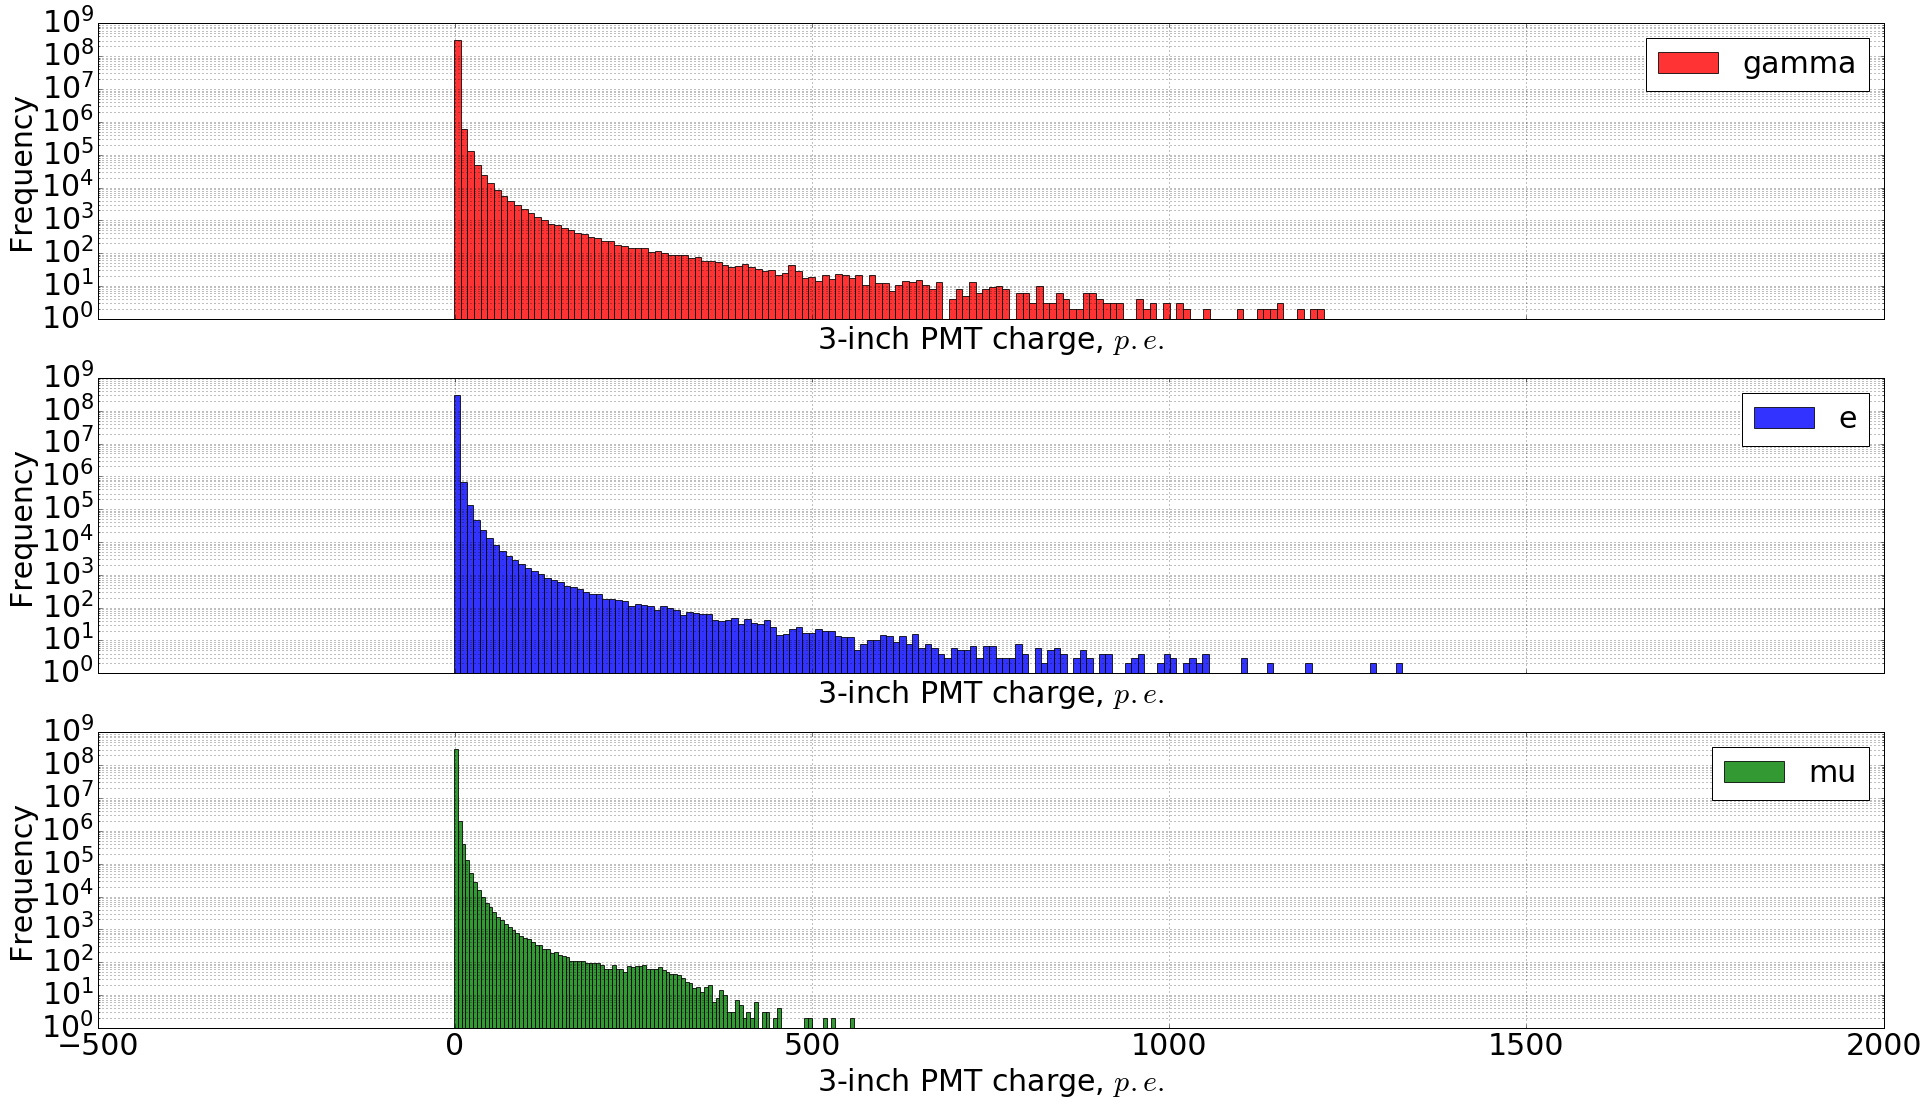

In [37]:
num_events = 10000
plot_dict = {}
for label in label_dict.keys():
    plot_dict[label] = select_event_charges[select_labels == label][:num_events].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

print("Plotting the raw charge distribution for {0} random events :".format(num_events))
for label in label_dict.keys():
    axes[label].hist(plot_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel(r"3-inch PMT charge, $p.e.$", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

2. Raw timing distribution

Plotting the raw timing distribution for 10000 random events :


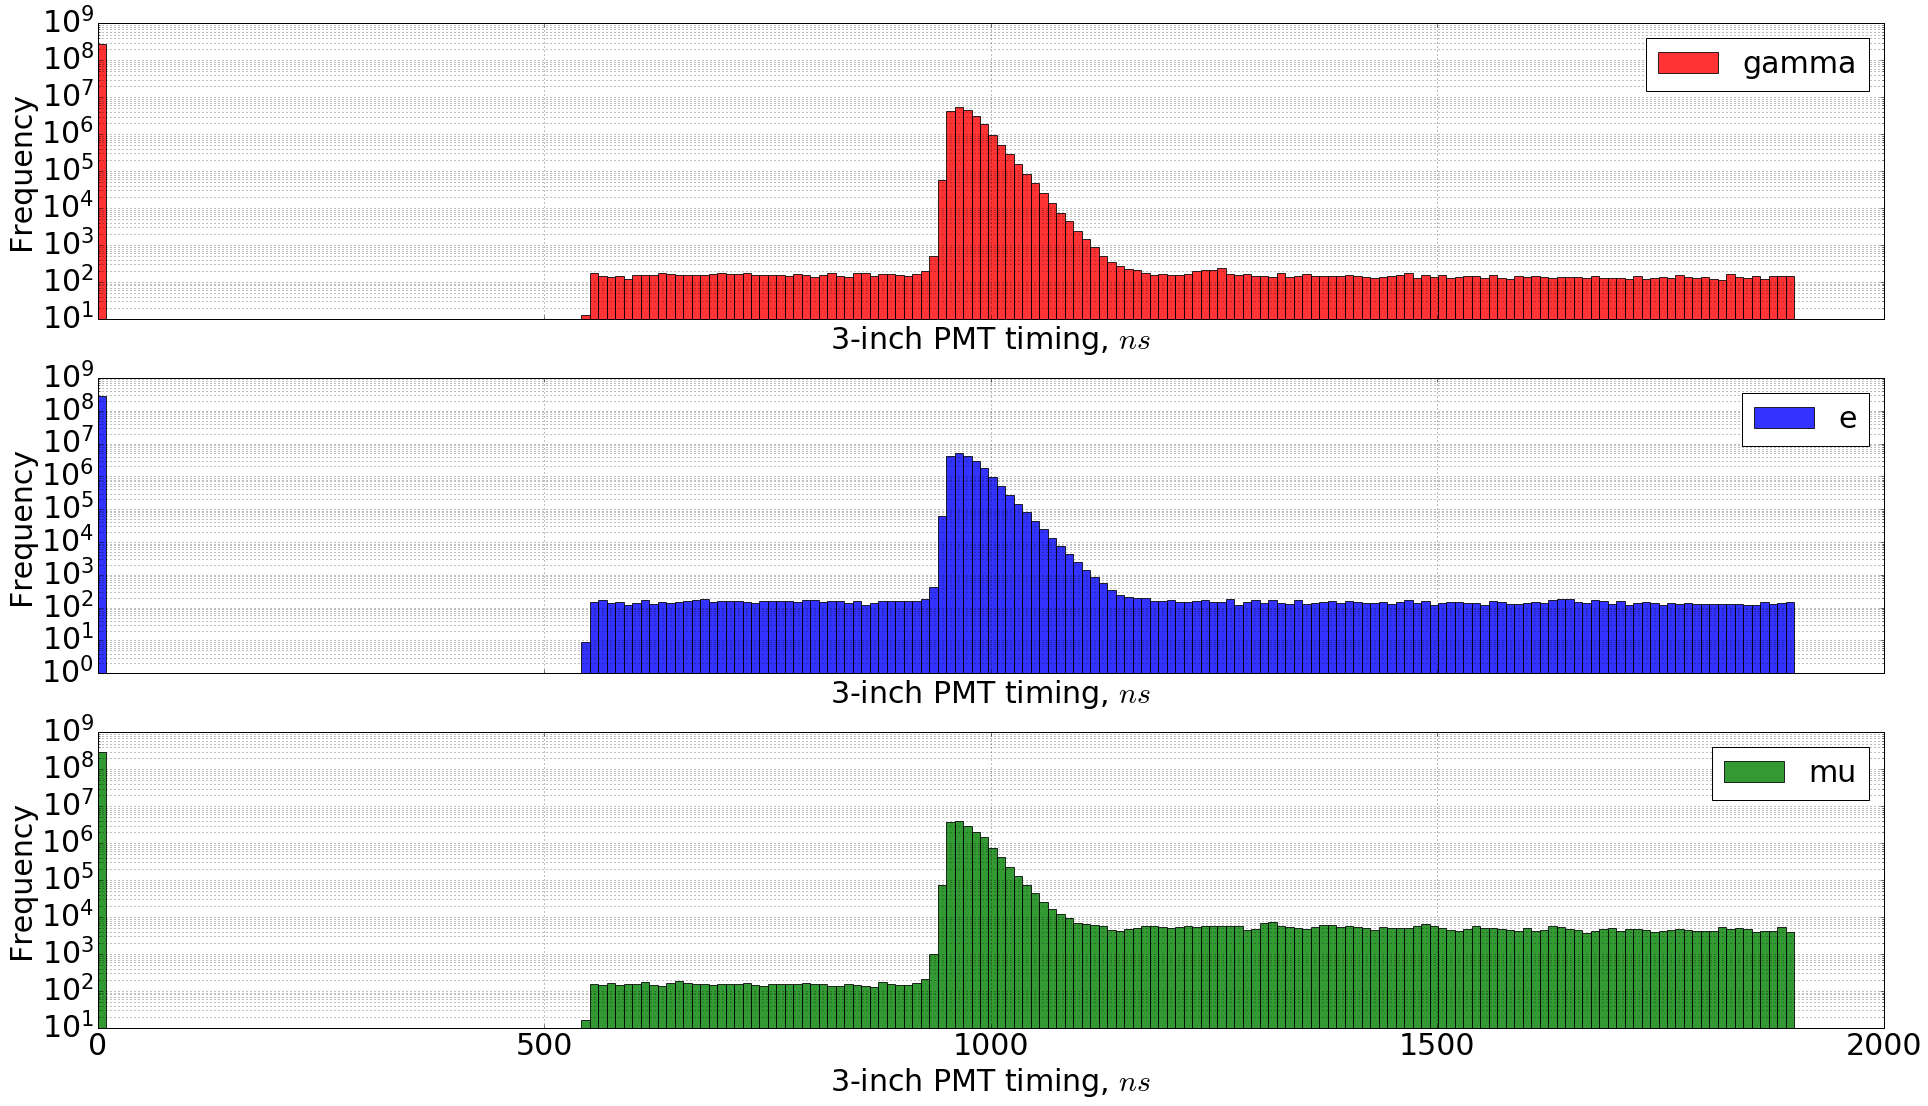

In [28]:
num_events = 10000
plot_dict = {}
for label in label_dict.keys():
    plot_dict[label] = select_event_timings[select_labels == label][:num_events].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

print("Plotting the raw timing distribution for {0} random events :".format(num_events))
for label in label_dict.keys():
    axes[label].hist(plot_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel(r"3-inch PMT timing, $ns$", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

3. Raw sum charge distribution

Plotting the raw charge distribution for 10000 random events :


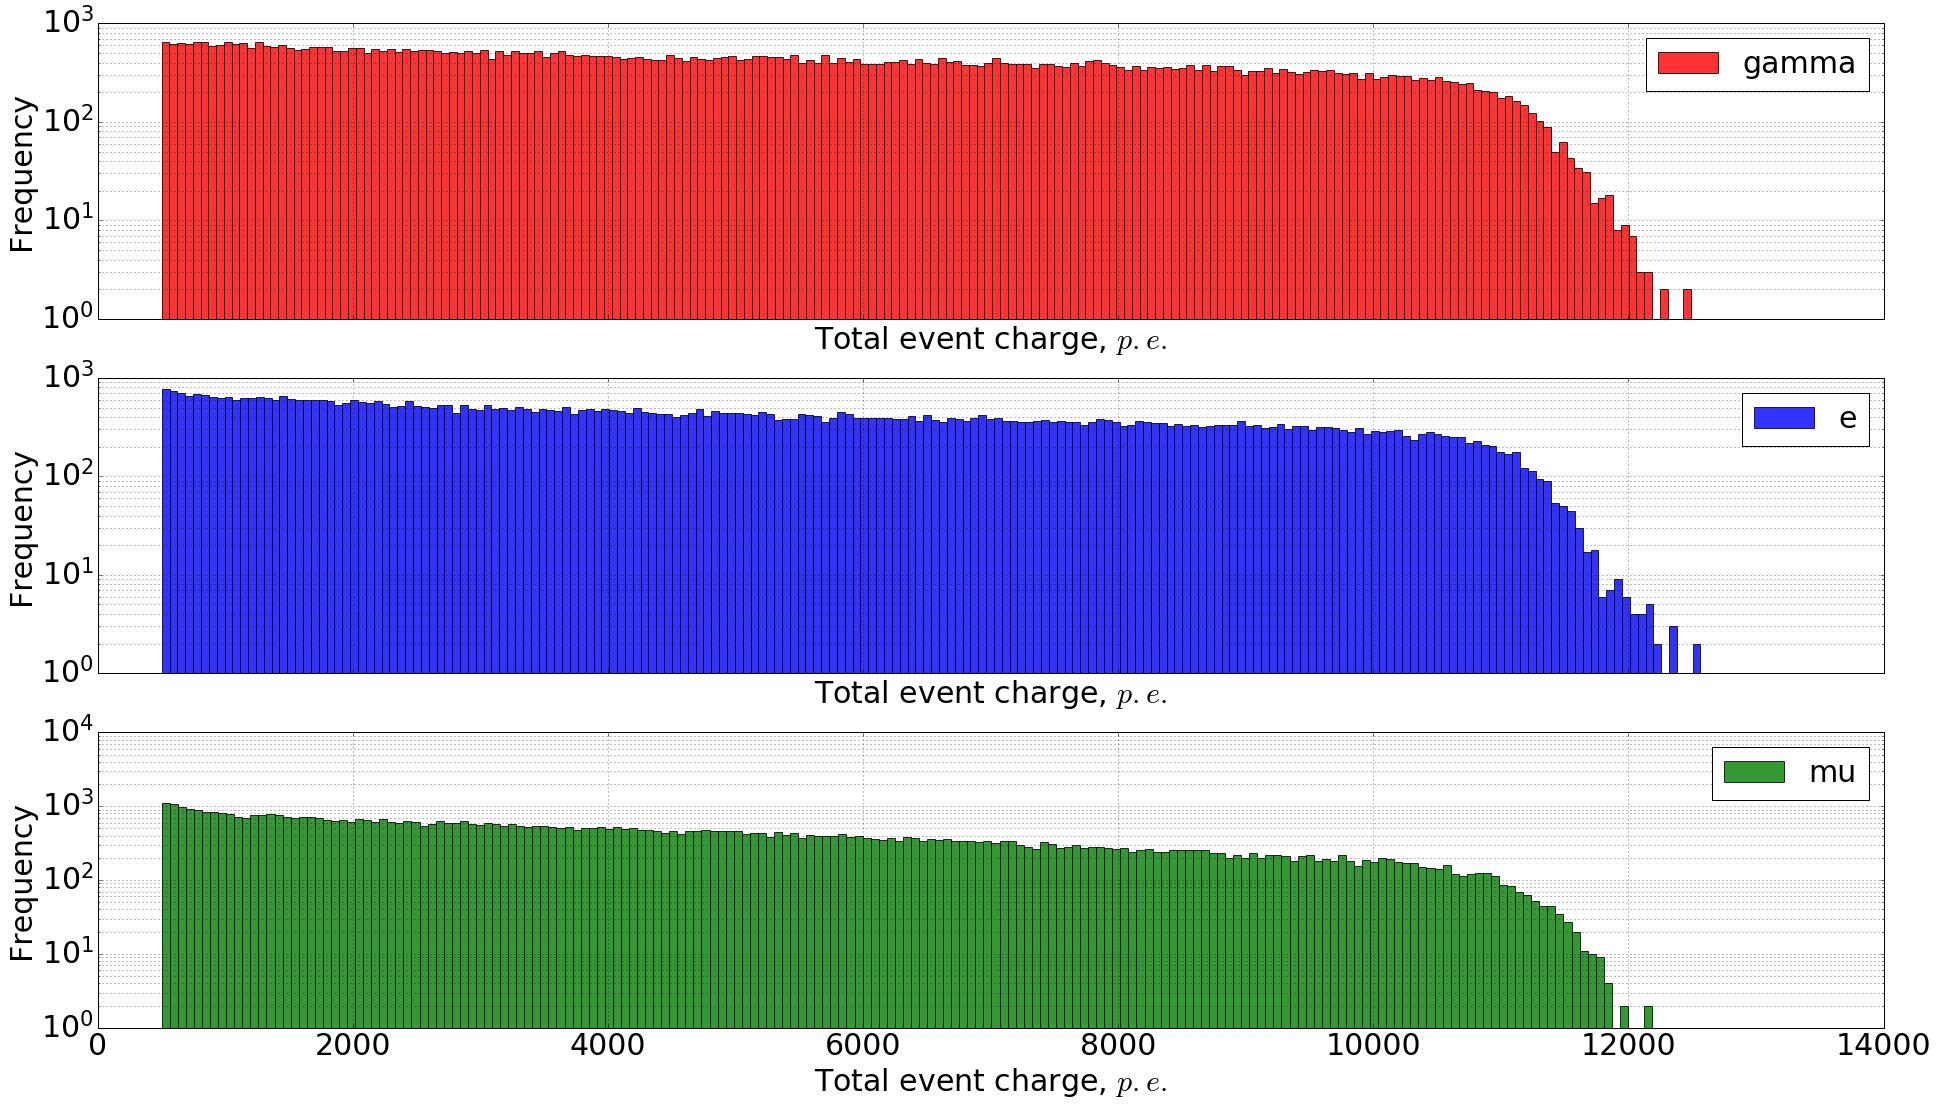

In [23]:
plot_dict = {}
for label in label_dict.keys():
    plot_dict[label] = select_sum_event_charges[select_labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(plot_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel(r"Total event charge, $p.e.$", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

### Normalization schemes and their impact on the data

### 1. From CS231n : Neural networks 2 (http://cs231n.github.io/neural-networks-2/)

a. Mean subtraction

In [31]:
num_samples = 1000

In [39]:
# For each charge and timing channel, apply mean subtraction to the grid
local_event_charges = select_event_charges[:num_samples]
local_event_timings = select_event_timings[:num_samples]
local_labels        = select_labels[:num_samples]

print(local_event_timings.shape, local_event_timings.shape, local_labels.shape)

(1000, 40, 40, 19) (1000, 40, 40, 19) (1000,)


The simplest way to do the mean subtraction is to consider the data as 2-d matrix of size (1000 x 30400) and apply mean subtraction along the num_samples dimension :

In [40]:
simple_event_charges = local_event_charges.reshape(local_event_charges.shape[0], -1)
simple_event_timings = local_event_timings.reshape(local_event_timings.shape[0], -1)

print(simple_event_timings.shape, simple_event_timings.shape)

(1000, 30400) (1000, 30400)


In [48]:
simple_event_charges -= np.mean(simple_event_charges, axis=0)
simple_event_timings -= np.mean(simple_event_timings, axis=0)

print(np.mean(simple_event_charges, axis=0)[:100], np.mean(simple_event_timings, axis=0)[:100],
      simple_event_timings.shape, simple_event_timings.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] (1000, 30400) (1000, 30400)


Plot the raw charge distribution and the simple mean subtracted distributions

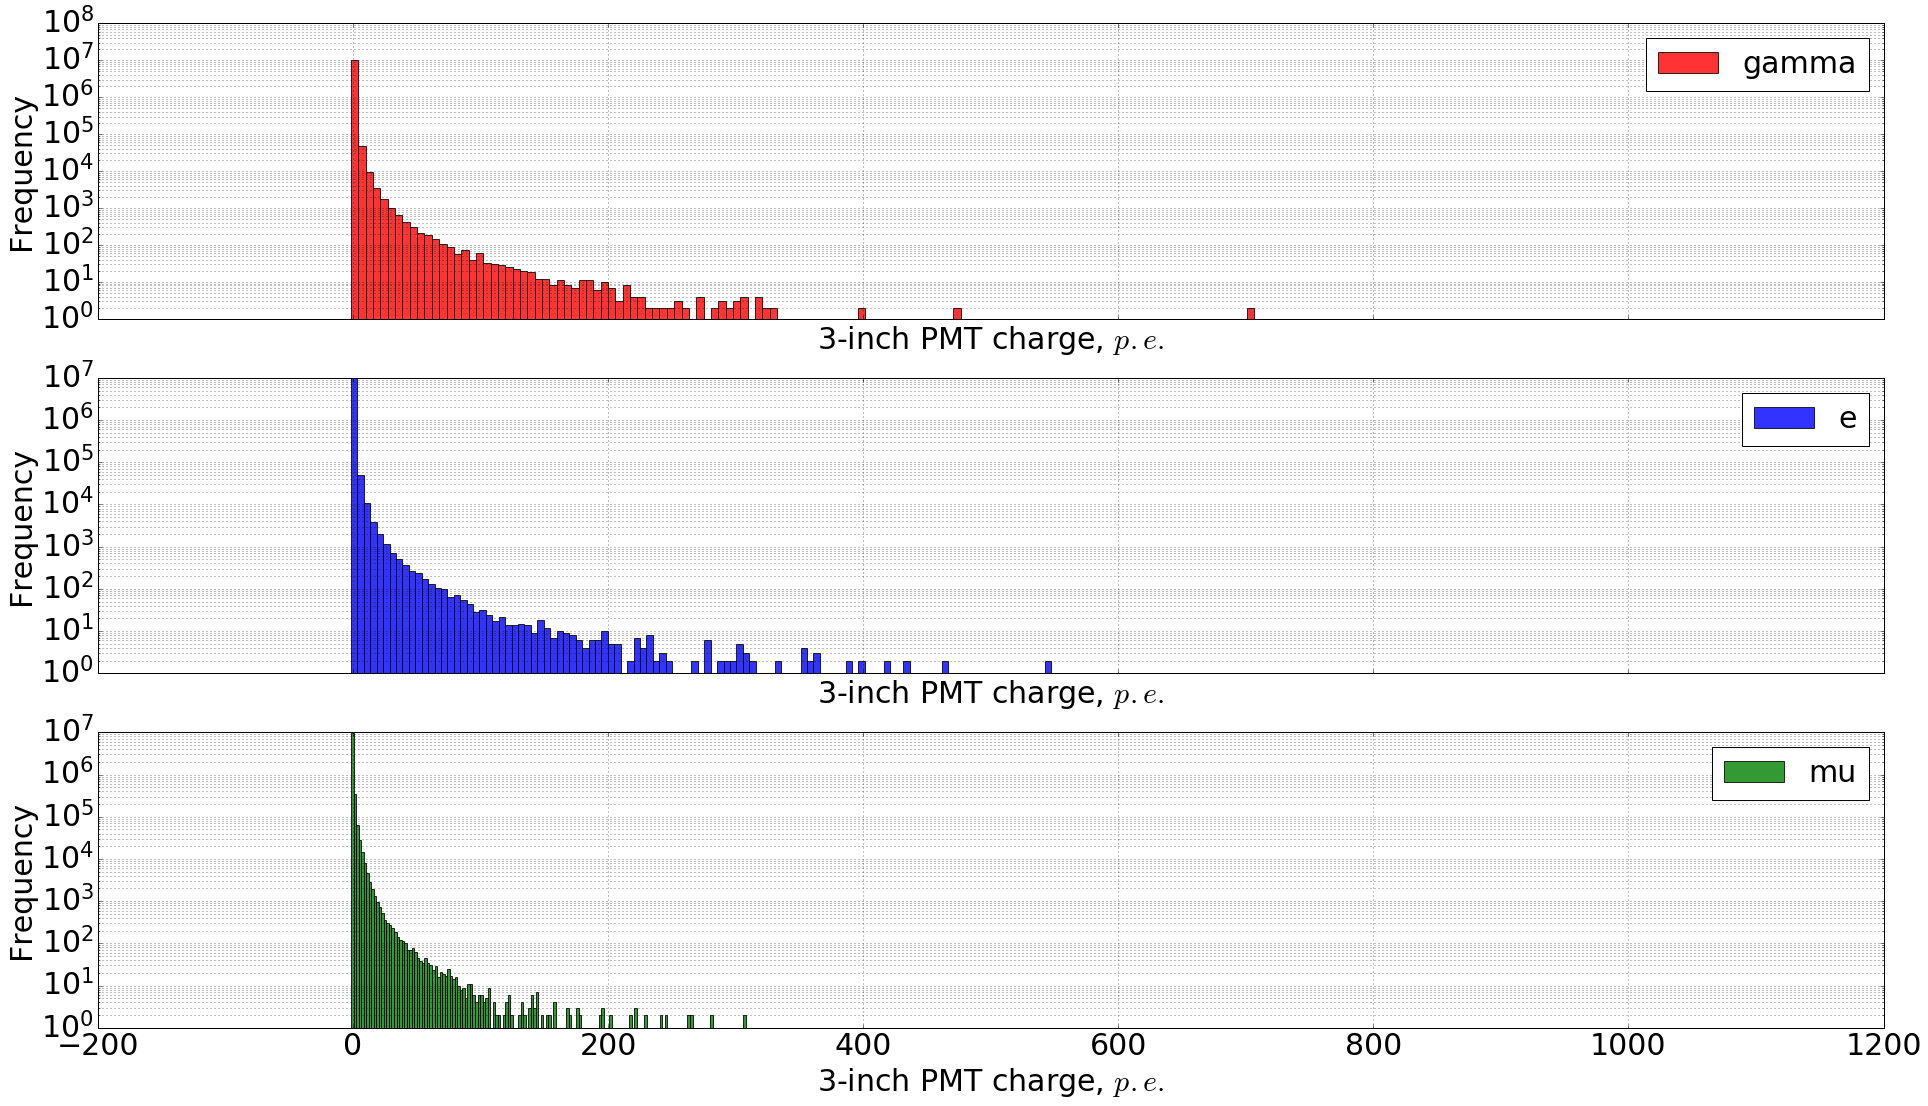

In [45]:
plot_dict = {}
for label in label_dict.keys():
    plot_dict[label] = local_event_charges[local_labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(plot_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel(r"3-inch PMT charge, $p.e.$", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

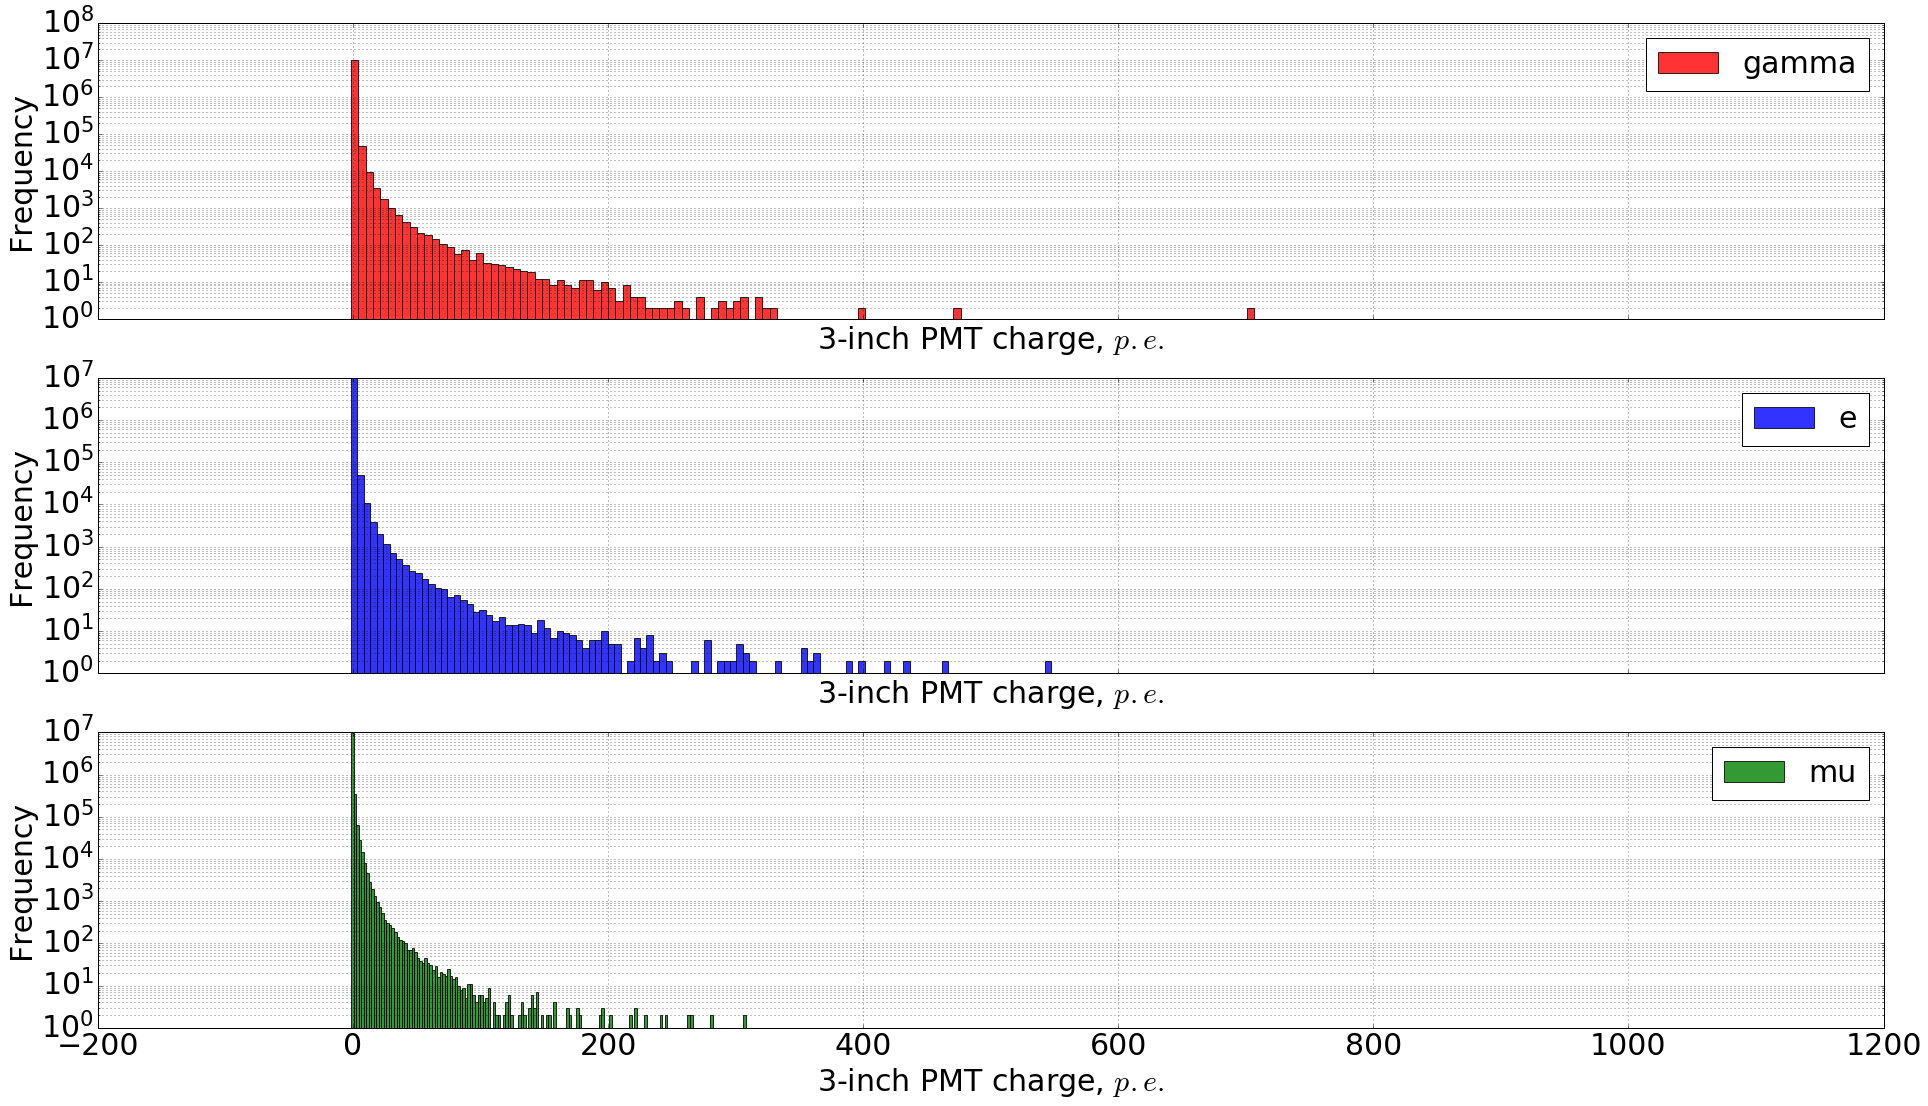

In [46]:
plot_dict = {}
for label in label_dict.keys():
    plot_dict[label] = simple_event_charges[local_labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(plot_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel(r"3-inch PMT charge, $p.e.$", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")